<a href="https://colab.research.google.com/github/psb-cc/aiss25-llm-pretraining/blob/main/AISS25_LLM_Pre_training_from_Scratch_%7C_puneetb_iiitd_ac_in.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AISS 2025: LLM Pretraining from Scratch*

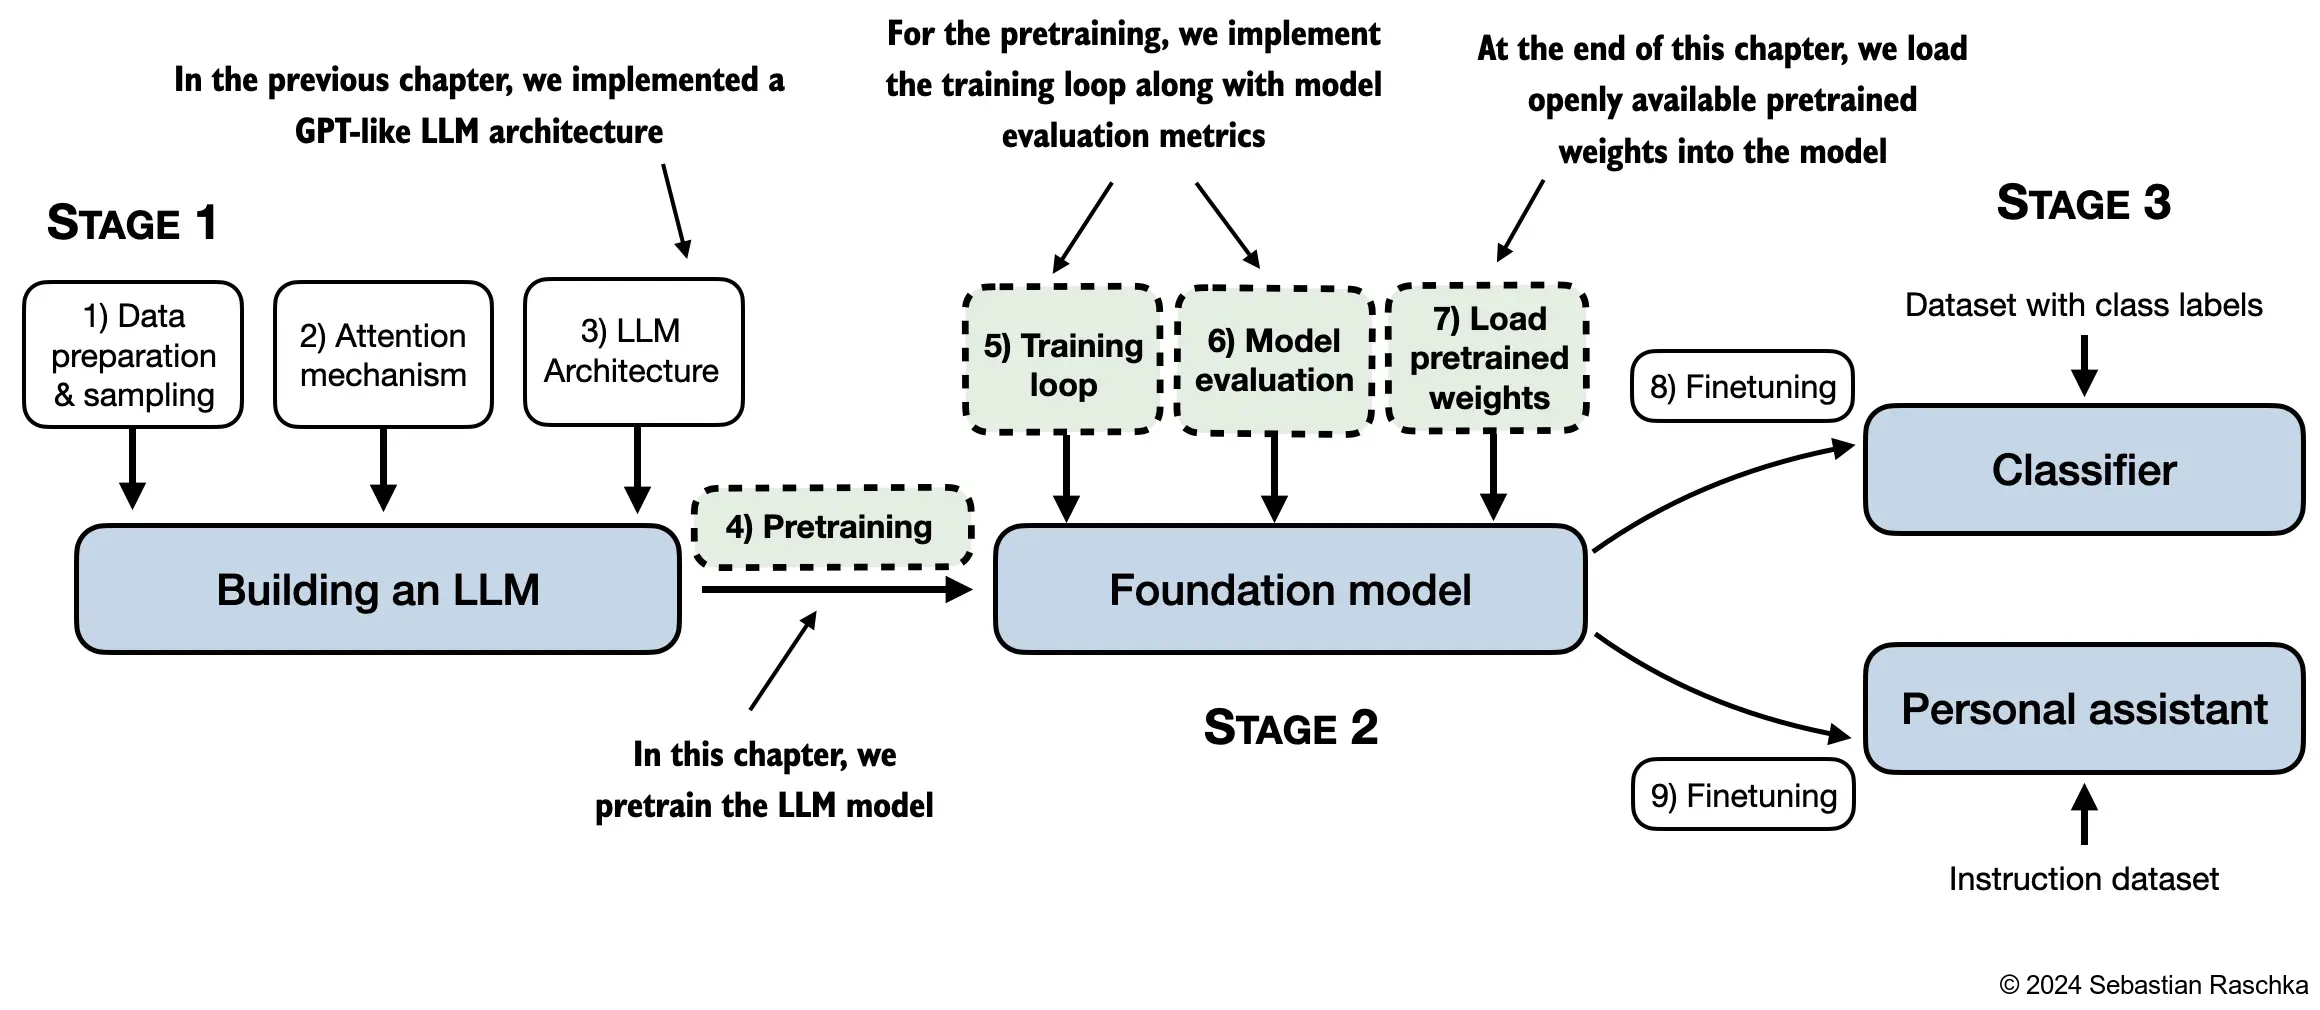

# imports and config

In [ ]:
import torch
import tiktoken
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-key-value bias
}


torch.manual_seed(110020)
np.random.seed(110020)

# dataset and dataloader

In [ ]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


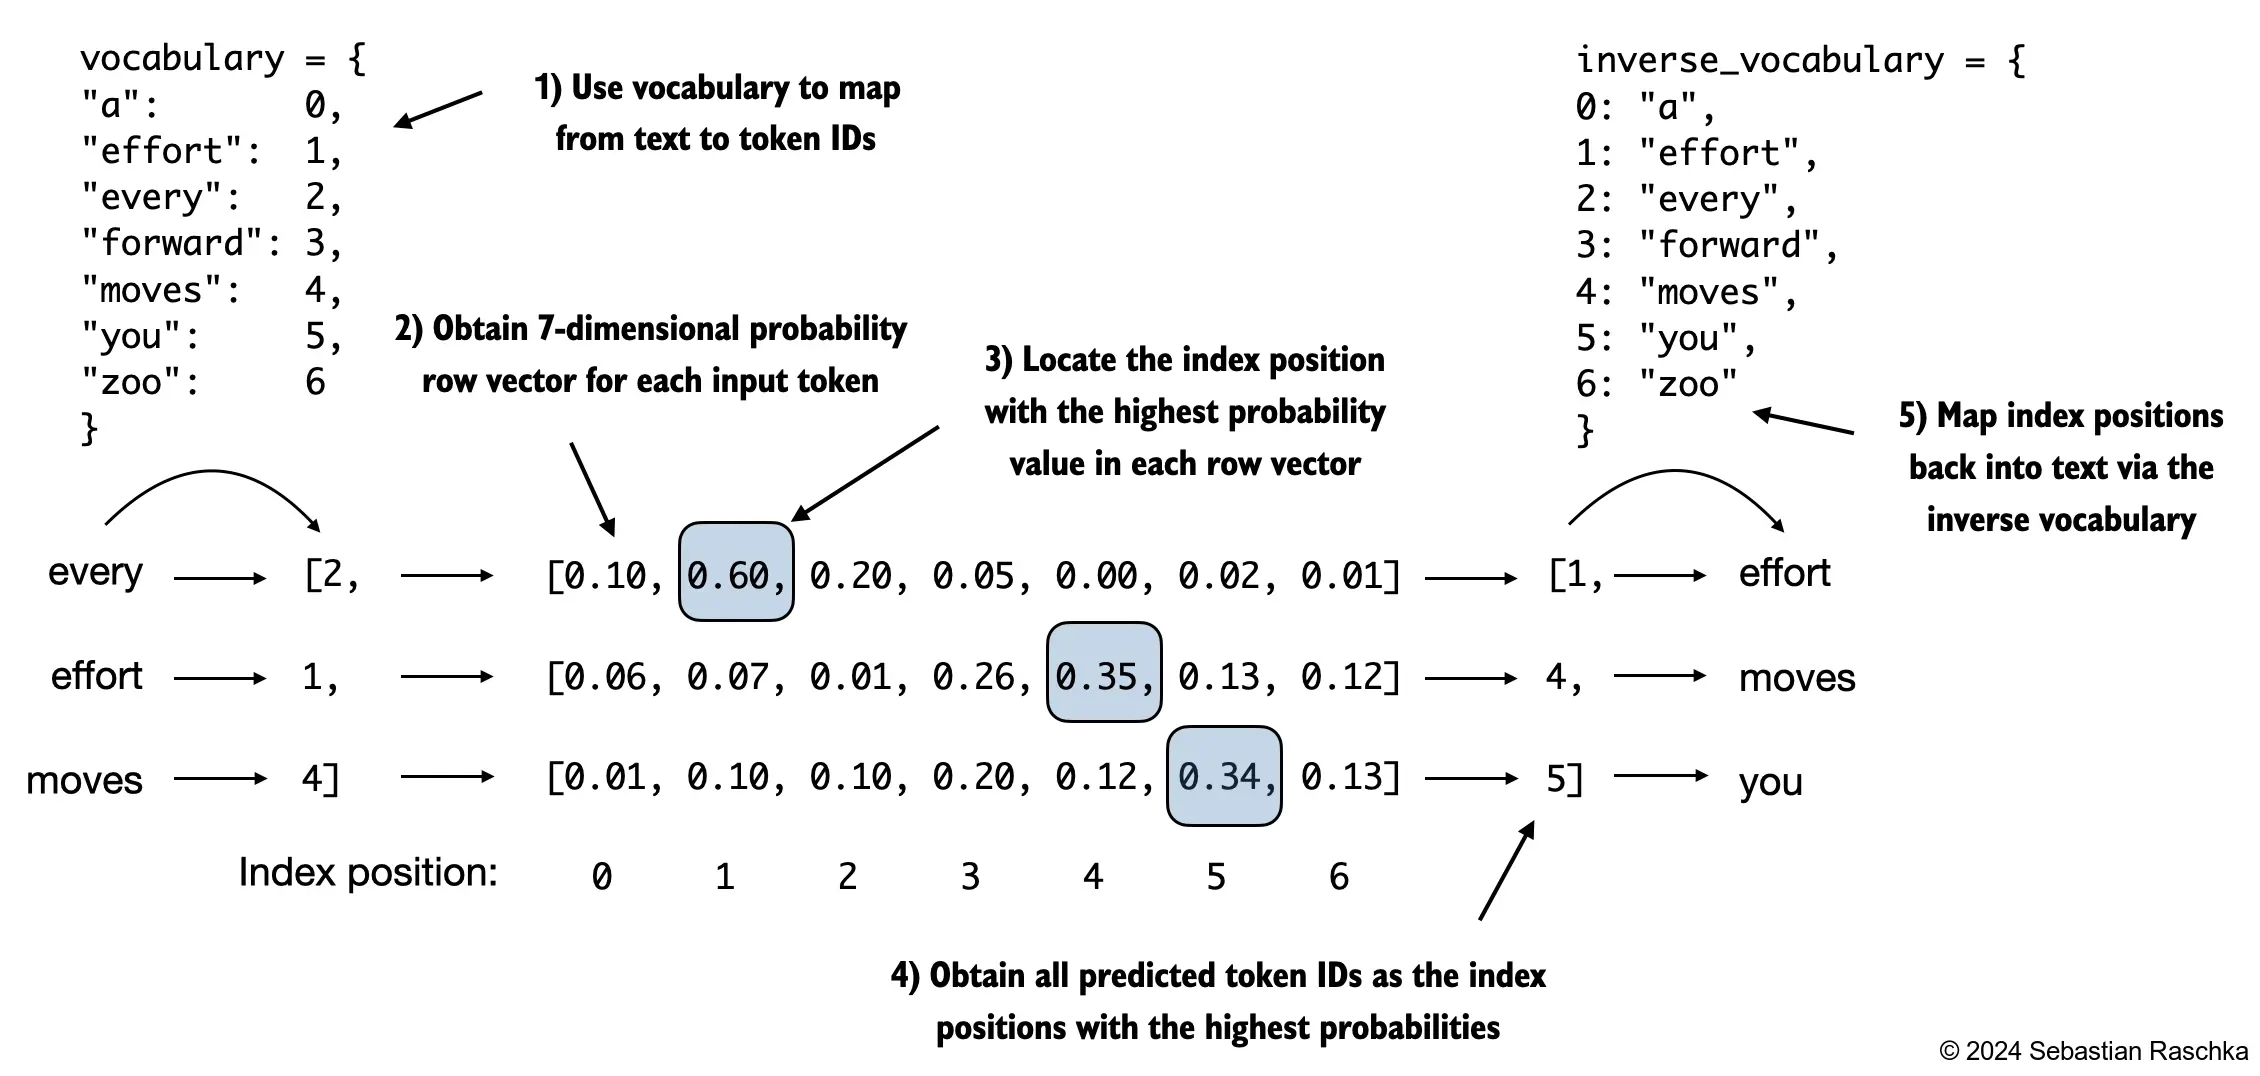

# multi head attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, _ = x.shape

        # get k, q, v
        keys = self.W_key(x)                                                    # [b, num_tokens, d_out]
        queries = self.W_query(x)                                               # [b, num_tokens, d_out]
        values = self.W_value(x)                                                # [b, num_tokens, d_out]

        # make heads
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)          # [b, num_tokens, num_heads, head_dim]
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)      # [b, num_tokens, num_heads, head_dim]
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)    # [b, num_tokens, num_heads, head_dim]

        # reshaping to facilitate multiplication
        keys = keys.transpose(1, 2)                                             # [b, num_heads, num_tokens, head_dim]
        queries = queries.transpose(1, 2)                                       # [b, num_heads, num_tokens, head_dim]
        values = values.transpose(1, 2)                                         # [b, num_heads, num_tokens, head_dim]

        # calculate attention scores using bmm
        attn_scores = queries @ keys.transpose(2, 3)                            # [b, num_heads, num_tokens, head_dim], [b, num_heads, head_dim, num_tokens] --> [b, num_heads, num_tokens, num_tokens]

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]                  # [num_tokens, num_tokens]

        # Use the mask to fill attention scores ensuring autoregressive mask
        attn_scores.masked_fill_(mask_bool, -torch.inf)                         # [b, num_heads, num_tokens, num_tokens]

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1) # [b, num_heads, num_tokens, num_tokens] "the last num_tokens dimension is normalised"
        attn_weights = self.dropout(attn_weights)                               # [b, num_heads, num_tokens, num_tokens]

        # calculate context vector
        context_vec = (attn_weights @ values).transpose(1, 2)                   # [b, num_heads, num_tokens, num_tokens], [b, num_heads, num_tokens, head_dim] --> [b, num_tokens, num_heads, head_dim]

        # concatenate all the heads
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)            # [b, num_tokens, d_out] "d_out = num_heads * head_dim"
        context_vec = self.out_proj(context_vec)                                # [b, num_tokens, d_out]

        return context_vec


# model

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)                                       # [b, seq_len, emb_dim]
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))  # [seq_len]
        x = tok_embeds + pos_embeds                                             # [b, seq_len, emb_dim], [seq_len] --> [b, seq_len, emb_dim]
        x = self.drop_emb(x)                                                    # [b, seq_len, emb_dim]
        x = self.trf_blocks(x)                                                  # [b, seq_len, emb_dim]
        x = self.final_norm(x)                                                  # [b, seq_len, emb_dim]
        logits = self.out_head(x)                                               # [b, seq_len, voacb_size]
        return logits

    def generate_text(self, input_ids, max_new_tokens):
        batch_size, seq_len = input_ids.shape
        # truncate input_ids to context_len
        input_ids = input_ids[:, -CONFIG["context_length"]:]
        for _ in range(max_new_tokens):
            with torch.no_grad():
                logits = self(input_ids)
                logits = logits[:, -1, :]
                probs = torch.softmax(logits, dim=-1)
                next_token_id = torch.argmax(probs, dim=-1, keepdim=True)
                input_ids = torch.cat((input_ids, next_token_id), dim=1)
        return input_ids

# training loop

In [ ]:
import os
import urllib.request

file_path = "./t8.shakespeare.txt"
with open(file_path) as file:
    text_data = file.read()


In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(len(train_data))
print(len(val_data))

4912379
545820


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = GPTDatasetV1(
    txt=train_data,
    tokenizer=tokenizer,
    max_length=CONFIG["context_length"],
    stride=128
)

val_dataset = GPTDatasetV1(
    txt=val_data,
    tokenizer=tokenizer,
    max_length=CONFIG["context_length"],
    stride=128
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

model = GPTModel(CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

num_epochs = 10

In [ ]:
train_losses, val_losses = [], []
tokens_seen, global_step = 0, -1

prompt = "taylor swift travelled using the falcon "
prompt_input_ids = tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})
prompt_input_ids = torch.tensor(prompt_input_ids).unsqueeze(0).to(device)

for epoch in range(10):
    model.train()  # Set model to training mode

    train_loss_this_epoch = 0
    for input_batch, target_batch in tqdm(train_dataloader):
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        logits = model(input_batch) # Forward pass
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        train_loss_this_epoch += loss.item()
    train_losses.append(train_loss_this_epoch / len(train_dataloader))

    model.eval()  # Set model to evaluation mode

    val_loss_this_epoch = 0
    for input_batch, output_batch in tqdm(val_dataloader):
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        with torch.no_grad():
            logits = model(input_batch)
            loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), output_batch.flatten())
            val_loss_this_epoch += loss.item()
    val_losses.append(val_loss_this_epoch / len(val_dataloader))

    print(f"Epoch: {epoch} | Train Loss: {train_loss_this_epoch / len(train_dataloader)} | Val Loss: {val_loss_this_epoch / len(val_dataloader)}")

    generated_token_ids = model.generate_text(prompt_input_ids, 10)[0].tolist()
    generated_text = tokenizer.decode(generated_token_ids)
    print(generated_text)

    # save the model
    torch.save(model.state_dict(), f"model_loss_{val_losses[-1]}.pth")

 15%|█▌        | 994/6501 [03:20<18:34,  4.94it/s]

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

# inference

In [ ]:
prompt = "taylor swift travelled using the falcon"
prompt_input_ids = tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})
prompt_input_ids = torch.tensor(prompt_input_ids).unsqueeze(0).to(device)
generated_token_ids = model.generate_text(prompt_input_ids, 10)[0].tolist()
generated_text = tokenizer.decode(generated_token_ids)
print(generated_text)